In [1]:
import torch
import math
import matplotlib.pyplot as plt
torch.set_grad_enabled (False);


# Activation functions

In [2]:
class Tanh():  
    def forward(self, *input):
        self.s=input[0]
        return input[0].tanh()
    
    def backward(self, *gradwrtoutput):
        dl_dx=gradwrtoutput[0]
        dl_ds=(4 * (self.s.exp() + self.s.mul(-1).exp()).pow(-2))*dl_dx
        return dl_ds
    
    def param(self):
        return []  
    def reset(self):
        return []
    def update(self,eta):
        return []
    
class Relu():
    def forward(self, *input):
        self.s=input[0]
        return input[0].relu()
    
    def backward(self, *gradwrtoutput):
        dl_dx=gradwrtoutput[0]
        dl_ds=(self.s>0).float()*dl_dx
        return dl_ds
    
    def param(self):
        return []  
    def reset(self):
        return []
    def update(self,eta):
        return []

class Sigmoid():
    def forward(self, *input):
        self.s=input[0]
        return input[0].sigmoid()
    
    def backward(self, *gradwrtoutput):
        dl_dx=gradwrtoutput[0]
        dl_ds=(self.s.mul(-1).exp()/(1+self.s.mul(-1).exp()).pow(2))*dl_dx
        return dl_ds
    
    def param(self):
        return []  
    def reset(self):
        return []
    def update(self,eta):
        return []    
    

# Layers and criterions

In [3]:
#  input in a tuple of tensor composed of the weights, the bias and the input vector   
# and return a tuple composed of the in put vector and the output vector
class Linear():
       
    def __init__(self,n_in,n_out):      
        self.w = torch.empty(n_out, n_in).normal_()
        self.b =torch.empty(n_out).normal_()
        
        self.dl_dw = torch.empty(self.w.size())
        self.dl_db = torch.empty(self.b.size())
        self.x=torch.empty(n_in)
        
    def reset(self):
        self.dl_dw.zero_()
        self.dl_db.zero_()
    
    def forward(self, *input):
        self.x=input[0]
        return self.w.mv(self.x)+self.b
    
    def backward(self, *gradwrtoutput):
        dl_ds=gradwrtoutput[0]
        dl_dx=self.w.t().mv(dl_ds)
        self.dl_dw.add_(dl_ds.view(-1,1).mm(self.x.view(1,-1)))
        self.dl_db.add_(dl_ds)
        return dl_dx
        
    def param(self):
        return [[self.w,self.dl_dw],[self.b, self.dl_db]]
    
    def update(self,eta):
        self.w -= eta * self.dl_dw
        self.b -= eta * self.dl_db

class LossMSE():
    def loss(self,x,target):
        return (x - target).pow(2).sum()

    def dloss(self,x,target):
        dl_dx=2 * (x - target)
        return dl_dx
    
class LossMAE():
    def loss(self,x,target):
        return abs(x - target).sum()

    def dloss(self,x,target):
        dl_dx=(x-target>0).float()*2-1
        return dl_dx
    
class CrossEntroyLoss():
    def loss(self,x,target):    
        return x.softmax(-1)[target].log().mul(-1)

    def dloss(self,x,target):
        dl_dx=x.softmax(-1)
        dl_dx[target].add_(-1)
        return dl_dx
    
    
class Sequential():
    def __init__(self,loss_method,*modules):
        self.network=modules
        self.loss_method=loss_method
        
    def forward(self,input):
        x=input
        for module in self.network:
            x=module.forward(x)
        return x
    
    def backward(self,output,target):
        x=loss_method.dloss(output,target)
        #go through the network backward
        for module in self.network[::-1]:
            x=module.backward(x)
        
    

In [4]:
x=torch.tensor(.5)
target=torch.tensor(1.2)
(x*target<1).float()*-target

tensor(-1.2000)

# test

In [5]:
def generate_disc_set(nb):
    input = torch.Tensor(nb, 2).uniform_(0, 1)
    target = input.sub(0.5).pow(2).sum(1).sub(1/ (2*math.pi)).sign().sub(1).div(-2).long()
    return input, target

In [6]:
# import matplotlib.pyplot as plt
# point,color=generate_disc_set(10000)
# fig=plt.figure(figsize=(8, 8))
# plt.scatter(point[:,0],point[:,1],c=color,marker='.')
# plt.show()
# sum(color)

# MSE Loss 

In [15]:
train_input,train_target=generate_disc_set(1000)
test_input,test_target=generate_disc_set(1000)

mean, std = train_input.mean(), train_input.std()
train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)


err_epoch_mae=torch.empty(2000,10)
eta=1e-3
for n in range(1):
    loss_method=LossMSE()
    net=Sequential(loss_method,Linear(2,25),Tanh(),Linear(25,1),Sigmoid())

#     loss_method=LossMAE()
#     net=Sequential(loss_method,Linear(2,25),Relu(),Linear(25,1),Sigmoid())
    for i in range(2000):
        acc_loss = 0
        nb_train_errors = 0
        nb_test_errors = 0

        for module in net.network:
            module.reset()
        for j in range(train_target.shape[0]):  
            output=net.forward(train_input[j,:])
            nb_train_errors+=int(bool(output>0.5)!=bool(train_target[j]))
            acc_loss += loss_method.loss(output,train_target[j]) 
            net.backward(output,train_target[j])
        for module in net.network:
    #         print(module.param())
            module.update(eta)

        #test
        for j in range(test_target.shape[0]):  
            output=net.forward(test_input[j,:])
            nb_test_errors+=int(bool(output>0.5)!=bool(test_target[j]))
        print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(i,
                  acc_loss,
                  (100 * nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))
        err_epoch_mae[i,n]=(nb_test_errors) / test_input.size(0)

0 acc_train_loss 391.91 acc_train_error 47.60% test_error 46.60%
1 acc_train_loss 373.77 acc_train_error 46.90% test_error 44.50%
2 acc_train_loss 354.55 acc_train_error 44.60% test_error 42.70%
3 acc_train_loss 333.09 acc_train_error 43.20% test_error 41.70%
4 acc_train_loss 308.42 acc_train_error 41.40% test_error 39.90%
5 acc_train_loss 280.32 acc_train_error 39.50% test_error 38.20%
6 acc_train_loss 250.16 acc_train_error 35.70% test_error 32.70%
7 acc_train_loss 221.77 acc_train_error 29.50% test_error 29.30%
8 acc_train_loss 200.28 acc_train_error 25.70% test_error 28.20%
9 acc_train_loss 187.14 acc_train_error 24.40% test_error 27.10%
10 acc_train_loss 178.74 acc_train_error 23.80% test_error 25.00%
11 acc_train_loss 171.74 acc_train_error 22.30% test_error 22.90%
12 acc_train_loss 165.29 acc_train_error 20.80% test_error 21.60%
13 acc_train_loss 159.33 acc_train_error 19.20% test_error 20.20%
14 acc_train_loss 153.84 acc_train_error 18.30% test_error 19.30%
15 acc_train_loss 14

129 acc_train_loss 56.99 acc_train_error 2.00% test_error 2.00%
130 acc_train_loss 56.82 acc_train_error 2.00% test_error 2.00%
131 acc_train_loss 56.64 acc_train_error 2.00% test_error 2.00%
132 acc_train_loss 56.46 acc_train_error 2.00% test_error 2.00%
133 acc_train_loss 56.29 acc_train_error 2.00% test_error 2.00%
134 acc_train_loss 56.12 acc_train_error 2.00% test_error 2.00%
135 acc_train_loss 55.95 acc_train_error 2.00% test_error 2.00%
136 acc_train_loss 55.78 acc_train_error 2.00% test_error 1.90%
137 acc_train_loss 55.61 acc_train_error 2.00% test_error 1.90%
138 acc_train_loss 55.44 acc_train_error 2.00% test_error 1.90%
139 acc_train_loss 55.28 acc_train_error 2.00% test_error 1.90%
140 acc_train_loss 55.12 acc_train_error 1.90% test_error 1.90%
141 acc_train_loss 54.95 acc_train_error 1.90% test_error 1.90%
142 acc_train_loss 54.79 acc_train_error 1.90% test_error 1.90%
143 acc_train_loss 54.64 acc_train_error 1.90% test_error 1.90%
144 acc_train_loss 54.48 acc_train_error

258 acc_train_loss 42.55 acc_train_error 1.50% test_error 1.60%
259 acc_train_loss 42.48 acc_train_error 1.50% test_error 1.60%
260 acc_train_loss 42.41 acc_train_error 1.50% test_error 1.60%
261 acc_train_loss 42.34 acc_train_error 1.50% test_error 1.60%
262 acc_train_loss 42.27 acc_train_error 1.50% test_error 1.60%
263 acc_train_loss 42.20 acc_train_error 1.50% test_error 1.60%
264 acc_train_loss 42.13 acc_train_error 1.50% test_error 1.60%
265 acc_train_loss 42.07 acc_train_error 1.50% test_error 1.60%
266 acc_train_loss 42.00 acc_train_error 1.50% test_error 1.50%
267 acc_train_loss 41.93 acc_train_error 1.50% test_error 1.50%
268 acc_train_loss 41.86 acc_train_error 1.50% test_error 1.50%
269 acc_train_loss 41.80 acc_train_error 1.50% test_error 1.50%
270 acc_train_loss 41.73 acc_train_error 1.50% test_error 1.50%
271 acc_train_loss 41.66 acc_train_error 1.50% test_error 1.50%
272 acc_train_loss 41.60 acc_train_error 1.50% test_error 1.50%
273 acc_train_loss 41.53 acc_train_error

387 acc_train_loss 35.74 acc_train_error 1.10% test_error 1.50%
388 acc_train_loss 35.70 acc_train_error 1.10% test_error 1.50%
389 acc_train_loss 35.66 acc_train_error 1.10% test_error 1.50%
390 acc_train_loss 35.62 acc_train_error 1.10% test_error 1.50%
391 acc_train_loss 35.58 acc_train_error 1.10% test_error 1.50%
392 acc_train_loss 35.54 acc_train_error 1.10% test_error 1.50%
393 acc_train_loss 35.50 acc_train_error 1.20% test_error 1.50%
394 acc_train_loss 35.47 acc_train_error 1.20% test_error 1.50%
395 acc_train_loss 35.43 acc_train_error 1.20% test_error 1.50%
396 acc_train_loss 35.39 acc_train_error 1.20% test_error 1.50%
397 acc_train_loss 35.35 acc_train_error 1.20% test_error 1.50%
398 acc_train_loss 35.31 acc_train_error 1.20% test_error 1.50%
399 acc_train_loss 35.27 acc_train_error 1.20% test_error 1.50%
400 acc_train_loss 35.24 acc_train_error 1.20% test_error 1.50%
401 acc_train_loss 35.20 acc_train_error 1.10% test_error 1.50%
402 acc_train_loss 35.16 acc_train_error

516 acc_train_loss 31.60 acc_train_error 1.20% test_error 1.50%
517 acc_train_loss 31.58 acc_train_error 1.20% test_error 1.50%
518 acc_train_loss 31.55 acc_train_error 1.20% test_error 1.50%
519 acc_train_loss 31.53 acc_train_error 1.20% test_error 1.50%
520 acc_train_loss 31.50 acc_train_error 1.20% test_error 1.50%
521 acc_train_loss 31.47 acc_train_error 1.20% test_error 1.50%
522 acc_train_loss 31.45 acc_train_error 1.20% test_error 1.50%
523 acc_train_loss 31.42 acc_train_error 1.20% test_error 1.50%
524 acc_train_loss 31.40 acc_train_error 1.20% test_error 1.50%
525 acc_train_loss 31.37 acc_train_error 1.20% test_error 1.50%
526 acc_train_loss 31.35 acc_train_error 1.20% test_error 1.50%
527 acc_train_loss 31.32 acc_train_error 1.20% test_error 1.50%
528 acc_train_loss 31.30 acc_train_error 1.20% test_error 1.50%
529 acc_train_loss 31.27 acc_train_error 1.20% test_error 1.50%
530 acc_train_loss 31.25 acc_train_error 1.20% test_error 1.50%
531 acc_train_loss 31.22 acc_train_error

645 acc_train_loss 28.76 acc_train_error 1.20% test_error 1.50%
646 acc_train_loss 28.74 acc_train_error 1.20% test_error 1.50%
647 acc_train_loss 28.72 acc_train_error 1.20% test_error 1.50%
648 acc_train_loss 28.70 acc_train_error 1.20% test_error 1.50%
649 acc_train_loss 28.69 acc_train_error 1.20% test_error 1.50%
650 acc_train_loss 28.67 acc_train_error 1.20% test_error 1.50%
651 acc_train_loss 28.65 acc_train_error 1.20% test_error 1.50%
652 acc_train_loss 28.63 acc_train_error 1.20% test_error 1.40%
653 acc_train_loss 28.61 acc_train_error 1.20% test_error 1.40%
654 acc_train_loss 28.59 acc_train_error 1.20% test_error 1.40%
655 acc_train_loss 28.57 acc_train_error 1.20% test_error 1.40%
656 acc_train_loss 28.56 acc_train_error 1.20% test_error 1.40%
657 acc_train_loss 28.54 acc_train_error 1.20% test_error 1.40%
658 acc_train_loss 28.52 acc_train_error 1.20% test_error 1.40%
659 acc_train_loss 28.50 acc_train_error 1.20% test_error 1.40%
660 acc_train_loss 28.48 acc_train_error

774 acc_train_loss 26.65 acc_train_error 1.00% test_error 1.50%
775 acc_train_loss 26.63 acc_train_error 1.00% test_error 1.50%
776 acc_train_loss 26.62 acc_train_error 1.00% test_error 1.50%
777 acc_train_loss 26.61 acc_train_error 1.00% test_error 1.50%
778 acc_train_loss 26.59 acc_train_error 1.00% test_error 1.50%
779 acc_train_loss 26.58 acc_train_error 1.00% test_error 1.50%
780 acc_train_loss 26.56 acc_train_error 1.00% test_error 1.50%
781 acc_train_loss 26.55 acc_train_error 1.00% test_error 1.50%
782 acc_train_loss 26.54 acc_train_error 1.00% test_error 1.50%
783 acc_train_loss 26.52 acc_train_error 1.00% test_error 1.50%
784 acc_train_loss 26.51 acc_train_error 1.00% test_error 1.50%
785 acc_train_loss 26.49 acc_train_error 1.00% test_error 1.50%
786 acc_train_loss 26.48 acc_train_error 1.00% test_error 1.50%
787 acc_train_loss 26.46 acc_train_error 1.00% test_error 1.50%
788 acc_train_loss 26.45 acc_train_error 1.00% test_error 1.50%
789 acc_train_loss 26.44 acc_train_error

903 acc_train_loss 25.00 acc_train_error 0.90% test_error 1.50%
904 acc_train_loss 24.99 acc_train_error 0.90% test_error 1.50%
905 acc_train_loss 24.97 acc_train_error 0.90% test_error 1.50%
906 acc_train_loss 24.96 acc_train_error 0.90% test_error 1.50%
907 acc_train_loss 24.95 acc_train_error 0.90% test_error 1.50%
908 acc_train_loss 24.94 acc_train_error 0.90% test_error 1.50%
909 acc_train_loss 24.93 acc_train_error 0.90% test_error 1.50%
910 acc_train_loss 24.92 acc_train_error 0.90% test_error 1.50%
911 acc_train_loss 24.91 acc_train_error 0.90% test_error 1.50%
912 acc_train_loss 24.90 acc_train_error 0.90% test_error 1.50%
913 acc_train_loss 24.88 acc_train_error 0.90% test_error 1.50%
914 acc_train_loss 24.87 acc_train_error 0.90% test_error 1.50%
915 acc_train_loss 24.86 acc_train_error 0.90% test_error 1.50%
916 acc_train_loss 24.85 acc_train_error 0.90% test_error 1.50%
917 acc_train_loss 24.84 acc_train_error 0.90% test_error 1.50%
918 acc_train_loss 24.83 acc_train_error

1031 acc_train_loss 23.67 acc_train_error 0.80% test_error 1.50%
1032 acc_train_loss 23.66 acc_train_error 0.80% test_error 1.50%
1033 acc_train_loss 23.65 acc_train_error 0.80% test_error 1.50%
1034 acc_train_loss 23.64 acc_train_error 0.80% test_error 1.50%
1035 acc_train_loss 23.63 acc_train_error 0.80% test_error 1.50%
1036 acc_train_loss 23.62 acc_train_error 0.80% test_error 1.50%
1037 acc_train_loss 23.61 acc_train_error 0.80% test_error 1.50%
1038 acc_train_loss 23.60 acc_train_error 0.80% test_error 1.50%
1039 acc_train_loss 23.59 acc_train_error 0.80% test_error 1.50%
1040 acc_train_loss 23.58 acc_train_error 0.80% test_error 1.50%
1041 acc_train_loss 23.57 acc_train_error 0.80% test_error 1.50%
1042 acc_train_loss 23.56 acc_train_error 0.80% test_error 1.50%
1043 acc_train_loss 23.55 acc_train_error 0.80% test_error 1.50%
1044 acc_train_loss 23.54 acc_train_error 0.80% test_error 1.50%
1045 acc_train_loss 23.54 acc_train_error 0.80% test_error 1.50%
1046 acc_train_loss 23.53

1158 acc_train_loss 22.56 acc_train_error 0.70% test_error 1.50%
1159 acc_train_loss 22.55 acc_train_error 0.70% test_error 1.50%
1160 acc_train_loss 22.55 acc_train_error 0.70% test_error 1.50%
1161 acc_train_loss 22.54 acc_train_error 0.70% test_error 1.50%
1162 acc_train_loss 22.53 acc_train_error 0.70% test_error 1.50%
1163 acc_train_loss 22.52 acc_train_error 0.70% test_error 1.50%
1164 acc_train_loss 22.51 acc_train_error 0.70% test_error 1.50%
1165 acc_train_loss 22.51 acc_train_error 0.70% test_error 1.50%
1166 acc_train_loss 22.50 acc_train_error 0.70% test_error 1.50%
1167 acc_train_loss 22.49 acc_train_error 0.70% test_error 1.50%
1168 acc_train_loss 22.48 acc_train_error 0.70% test_error 1.50%
1169 acc_train_loss 22.47 acc_train_error 0.70% test_error 1.50%
1170 acc_train_loss 22.47 acc_train_error 0.70% test_error 1.50%
1171 acc_train_loss 22.46 acc_train_error 0.70% test_error 1.50%
1172 acc_train_loss 22.45 acc_train_error 0.70% test_error 1.50%
1173 acc_train_loss 22.44

1285 acc_train_loss 21.62 acc_train_error 0.70% test_error 1.50%
1286 acc_train_loss 21.61 acc_train_error 0.70% test_error 1.50%
1287 acc_train_loss 21.60 acc_train_error 0.70% test_error 1.50%
1288 acc_train_loss 21.60 acc_train_error 0.70% test_error 1.50%
1289 acc_train_loss 21.59 acc_train_error 0.70% test_error 1.50%
1290 acc_train_loss 21.58 acc_train_error 0.70% test_error 1.50%
1291 acc_train_loss 21.58 acc_train_error 0.70% test_error 1.50%
1292 acc_train_loss 21.57 acc_train_error 0.70% test_error 1.50%
1293 acc_train_loss 21.56 acc_train_error 0.70% test_error 1.50%
1294 acc_train_loss 21.55 acc_train_error 0.70% test_error 1.50%
1295 acc_train_loss 21.55 acc_train_error 0.70% test_error 1.50%
1296 acc_train_loss 21.54 acc_train_error 0.70% test_error 1.50%
1297 acc_train_loss 21.53 acc_train_error 0.70% test_error 1.50%
1298 acc_train_loss 21.53 acc_train_error 0.70% test_error 1.50%
1299 acc_train_loss 21.52 acc_train_error 0.70% test_error 1.50%
1300 acc_train_loss 21.51

1412 acc_train_loss 20.79 acc_train_error 0.70% test_error 1.50%
1413 acc_train_loss 20.79 acc_train_error 0.70% test_error 1.50%
1414 acc_train_loss 20.78 acc_train_error 0.70% test_error 1.50%
1415 acc_train_loss 20.78 acc_train_error 0.70% test_error 1.50%
1416 acc_train_loss 20.77 acc_train_error 0.70% test_error 1.50%
1417 acc_train_loss 20.76 acc_train_error 0.70% test_error 1.50%
1418 acc_train_loss 20.76 acc_train_error 0.70% test_error 1.50%
1419 acc_train_loss 20.75 acc_train_error 0.70% test_error 1.50%
1420 acc_train_loss 20.75 acc_train_error 0.70% test_error 1.50%
1421 acc_train_loss 20.74 acc_train_error 0.70% test_error 1.50%
1422 acc_train_loss 20.73 acc_train_error 0.70% test_error 1.50%
1423 acc_train_loss 20.73 acc_train_error 0.70% test_error 1.50%
1424 acc_train_loss 20.72 acc_train_error 0.70% test_error 1.50%
1425 acc_train_loss 20.72 acc_train_error 0.70% test_error 1.50%
1426 acc_train_loss 20.71 acc_train_error 0.70% test_error 1.50%
1427 acc_train_loss 20.70

1539 acc_train_loss 20.07 acc_train_error 0.70% test_error 1.50%
1540 acc_train_loss 20.06 acc_train_error 0.70% test_error 1.50%
1541 acc_train_loss 20.06 acc_train_error 0.70% test_error 1.50%
1542 acc_train_loss 20.05 acc_train_error 0.70% test_error 1.50%
1543 acc_train_loss 20.05 acc_train_error 0.70% test_error 1.50%
1544 acc_train_loss 20.04 acc_train_error 0.70% test_error 1.50%
1545 acc_train_loss 20.04 acc_train_error 0.70% test_error 1.50%
1546 acc_train_loss 20.03 acc_train_error 0.70% test_error 1.50%
1547 acc_train_loss 20.03 acc_train_error 0.70% test_error 1.50%
1548 acc_train_loss 20.02 acc_train_error 0.70% test_error 1.50%
1549 acc_train_loss 20.02 acc_train_error 0.70% test_error 1.50%
1550 acc_train_loss 20.01 acc_train_error 0.70% test_error 1.50%
1551 acc_train_loss 20.01 acc_train_error 0.70% test_error 1.50%
1552 acc_train_loss 20.00 acc_train_error 0.70% test_error 1.50%
1553 acc_train_loss 19.99 acc_train_error 0.70% test_error 1.50%
1554 acc_train_loss 19.99

1666 acc_train_loss 19.42 acc_train_error 0.70% test_error 1.60%
1667 acc_train_loss 19.42 acc_train_error 0.70% test_error 1.60%
1668 acc_train_loss 19.41 acc_train_error 0.70% test_error 1.60%
1669 acc_train_loss 19.41 acc_train_error 0.70% test_error 1.60%
1670 acc_train_loss 19.40 acc_train_error 0.70% test_error 1.60%
1671 acc_train_loss 19.40 acc_train_error 0.70% test_error 1.60%
1672 acc_train_loss 19.39 acc_train_error 0.70% test_error 1.60%
1673 acc_train_loss 19.39 acc_train_error 0.70% test_error 1.60%
1674 acc_train_loss 19.38 acc_train_error 0.70% test_error 1.60%
1675 acc_train_loss 19.38 acc_train_error 0.70% test_error 1.60%
1676 acc_train_loss 19.38 acc_train_error 0.70% test_error 1.60%
1677 acc_train_loss 19.37 acc_train_error 0.70% test_error 1.60%
1678 acc_train_loss 19.37 acc_train_error 0.70% test_error 1.60%
1679 acc_train_loss 19.36 acc_train_error 0.70% test_error 1.60%
1680 acc_train_loss 19.36 acc_train_error 0.70% test_error 1.60%
1681 acc_train_loss 19.35

1793 acc_train_loss 18.84 acc_train_error 0.70% test_error 1.60%
1794 acc_train_loss 18.84 acc_train_error 0.70% test_error 1.60%
1795 acc_train_loss 18.83 acc_train_error 0.70% test_error 1.60%
1796 acc_train_loss 18.83 acc_train_error 0.70% test_error 1.60%
1797 acc_train_loss 18.82 acc_train_error 0.70% test_error 1.60%
1798 acc_train_loss 18.82 acc_train_error 0.70% test_error 1.60%
1799 acc_train_loss 18.82 acc_train_error 0.70% test_error 1.60%
1800 acc_train_loss 18.81 acc_train_error 0.70% test_error 1.60%
1801 acc_train_loss 18.81 acc_train_error 0.70% test_error 1.60%
1802 acc_train_loss 18.80 acc_train_error 0.70% test_error 1.60%
1803 acc_train_loss 18.80 acc_train_error 0.70% test_error 1.60%
1804 acc_train_loss 18.79 acc_train_error 0.70% test_error 1.60%
1805 acc_train_loss 18.79 acc_train_error 0.70% test_error 1.60%
1806 acc_train_loss 18.79 acc_train_error 0.70% test_error 1.60%
1807 acc_train_loss 18.78 acc_train_error 0.70% test_error 1.60%
1808 acc_train_loss 18.78

1920 acc_train_loss 18.31 acc_train_error 0.70% test_error 1.60%
1921 acc_train_loss 18.31 acc_train_error 0.70% test_error 1.60%
1922 acc_train_loss 18.31 acc_train_error 0.70% test_error 1.60%
1923 acc_train_loss 18.30 acc_train_error 0.70% test_error 1.60%
1924 acc_train_loss 18.30 acc_train_error 0.70% test_error 1.60%
1925 acc_train_loss 18.29 acc_train_error 0.70% test_error 1.60%
1926 acc_train_loss 18.29 acc_train_error 0.70% test_error 1.60%
1927 acc_train_loss 18.29 acc_train_error 0.70% test_error 1.60%
1928 acc_train_loss 18.28 acc_train_error 0.70% test_error 1.60%
1929 acc_train_loss 18.28 acc_train_error 0.70% test_error 1.60%
1930 acc_train_loss 18.28 acc_train_error 0.70% test_error 1.60%
1931 acc_train_loss 18.27 acc_train_error 0.70% test_error 1.60%
1932 acc_train_loss 18.27 acc_train_error 0.70% test_error 1.60%
1933 acc_train_loss 18.26 acc_train_error 0.70% test_error 1.60%
1934 acc_train_loss 18.26 acc_train_error 0.70% test_error 1.60%
1935 acc_train_loss 18.26

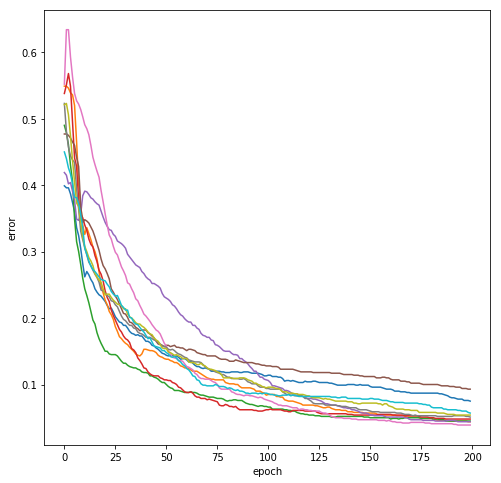

In [24]:
fig=plt.figure(figsize=(8, 8))

for i in range(10):
    plt.plot(range(200),err_epoch_cel[:,i].numpy())

plt.xlabel('epoch')
plt.ylabel('error')
plt.show()

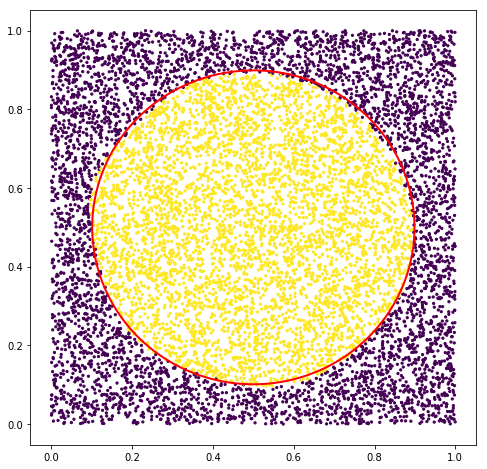

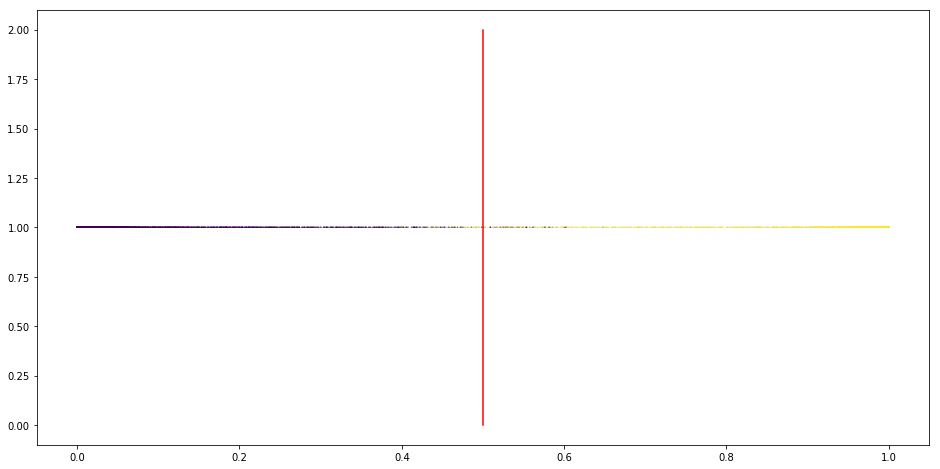

In [17]:
# LossMSE

test_input,test_target=generate_disc_set(10000)
test_input.sub_(mean).div_(std)
output=torch.empty(10000)
decision=torch.empty(10000)
for j in range(test_target.shape[0]):  
    output[j]=net.forward(test_input[j,:])
    decision[j]= int(bool(output[j]>0.5))


fig=plt.figure(figsize=(8, 8))
color=decision
circle1=plt.Circle((0.5,0.5), 1/math.sqrt(2*math.pi),linewidth=2 ,color='r',fill=False)
plt.gcf().gca().add_artist(circle1)
test_input.mul_(std).add_(mean)
plt.scatter(test_input[:,0],test_input[:,1],c=color,s=5)
plt.show()
        
test_input,test_target=generate_disc_set(10000)
test_input.sub_(mean).div_(std)
output=torch.empty(10000)
decision=torch.empty(10000)
for j in range(test_target.shape[0]):  
    output[j]=net.forward(test_input[j,:])

fig=plt.figure(figsize=(16, 8))
color=test_target
plt.scatter(output,torch.ones(10000),c=color,marker='.',s=0.2)
plt.plot([0.5,0.5],[0,2],'r')
plt.show()

# Cross entropy loss

In [9]:
torch.manual_seed(100)
train_input,train_target=generate_disc_set(1000)
test_input,test_target=generate_disc_set(1000)


mean, std = train_input.mean(), train_input.std()
train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

loss_method=CrossEntroyLoss()
# err_epoch_cel=torch.empty(200,10)
eta=1e-4



for n in range(1):
    net=Sequential(loss_method,Linear(2,25),Tanh(),Linear(25,2))
    for i in range(2000):
        acc_loss = 0
        nb_train_errors = 0
        nb_test_errors = 0

        for module in net.network:
            module.reset()
        for j in range(train_target.shape[0]):  
            output=net.forward(train_input[j,:])
            nb_train_errors+=int(bool(output.argmax())!=bool(train_target[j]))
            acc_loss += loss_method.loss(output,train_target[j]) 
            net.backward(output,train_target[j])
        for module in net.network:
    #         print(module.param())
            module.update(eta)

        #test
        for j in range(test_target.shape[0]):  
            output=net.forward(test_input[j,:])
            nb_test_errors+= int(bool(output.argmax())!=bool(test_target[j]))
        print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(i,
                  acc_loss,
                  (100 * nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))
#         err_epoch_cel[i,n]=(nb_test_errors) / test_input.size(0)

0 acc_train_loss 1162.48 acc_train_error 46.50% test_error 45.10%
1 acc_train_loss 864.35 acc_train_error 42.30% test_error 49.10%
2 acc_train_loss 787.16 acc_train_error 44.80% test_error 51.10%
3 acc_train_loss 762.37 acc_train_error 47.60% test_error 50.50%
4 acc_train_loss 744.62 acc_train_error 47.30% test_error 49.20%
5 acc_train_loss 728.56 acc_train_error 46.90% test_error 47.50%
6 acc_train_loss 713.39 acc_train_error 45.00% test_error 45.50%
7 acc_train_loss 698.94 acc_train_error 43.00% test_error 43.50%
8 acc_train_loss 685.18 acc_train_error 41.60% test_error 42.20%
9 acc_train_loss 672.06 acc_train_error 39.80% test_error 40.90%
10 acc_train_loss 659.58 acc_train_error 38.10% test_error 40.10%
11 acc_train_loss 647.70 acc_train_error 36.90% test_error 39.30%
12 acc_train_loss 636.39 acc_train_error 35.50% test_error 37.40%
13 acc_train_loss 625.64 acc_train_error 34.70% test_error 36.40%
14 acc_train_loss 615.42 acc_train_error 33.20% test_error 35.60%
15 acc_train_loss 6

125 acc_train_loss 298.22 acc_train_error 6.80% test_error 8.60%
126 acc_train_loss 297.12 acc_train_error 6.50% test_error 8.50%
127 acc_train_loss 296.02 acc_train_error 6.50% test_error 8.50%
128 acc_train_loss 294.94 acc_train_error 6.40% test_error 8.40%
129 acc_train_loss 293.87 acc_train_error 6.20% test_error 8.40%
130 acc_train_loss 292.80 acc_train_error 6.20% test_error 8.30%
131 acc_train_loss 291.75 acc_train_error 6.20% test_error 8.20%
132 acc_train_loss 290.71 acc_train_error 6.10% test_error 8.20%
133 acc_train_loss 289.68 acc_train_error 6.10% test_error 8.20%
134 acc_train_loss 288.66 acc_train_error 6.00% test_error 8.00%
135 acc_train_loss 287.65 acc_train_error 5.90% test_error 8.00%
136 acc_train_loss 286.65 acc_train_error 5.80% test_error 7.90%
137 acc_train_loss 285.66 acc_train_error 5.80% test_error 7.70%
138 acc_train_loss 284.67 acc_train_error 5.80% test_error 7.70%
139 acc_train_loss 283.70 acc_train_error 5.70% test_error 7.60%
140 acc_train_loss 282.74

252 acc_train_loss 214.17 acc_train_error 3.00% test_error 3.80%
253 acc_train_loss 213.78 acc_train_error 3.00% test_error 3.80%
254 acc_train_loss 213.39 acc_train_error 3.00% test_error 3.80%
255 acc_train_loss 213.00 acc_train_error 3.00% test_error 3.80%
256 acc_train_loss 212.62 acc_train_error 3.00% test_error 3.80%
257 acc_train_loss 212.24 acc_train_error 3.00% test_error 3.70%
258 acc_train_loss 211.86 acc_train_error 3.00% test_error 3.70%
259 acc_train_loss 211.48 acc_train_error 3.00% test_error 3.70%
260 acc_train_loss 211.11 acc_train_error 3.00% test_error 3.70%
261 acc_train_loss 210.74 acc_train_error 3.00% test_error 3.70%
262 acc_train_loss 210.37 acc_train_error 3.00% test_error 3.70%
263 acc_train_loss 210.00 acc_train_error 3.00% test_error 3.70%
264 acc_train_loss 209.63 acc_train_error 2.90% test_error 3.70%
265 acc_train_loss 209.27 acc_train_error 2.80% test_error 3.70%
266 acc_train_loss 208.91 acc_train_error 2.80% test_error 3.70%
267 acc_train_loss 208.55

379 acc_train_loss 177.94 acc_train_error 2.20% test_error 2.60%
380 acc_train_loss 177.72 acc_train_error 2.20% test_error 2.60%
381 acc_train_loss 177.52 acc_train_error 2.20% test_error 2.60%
382 acc_train_loss 177.31 acc_train_error 2.20% test_error 2.60%
383 acc_train_loss 177.10 acc_train_error 2.20% test_error 2.60%
384 acc_train_loss 176.89 acc_train_error 2.20% test_error 2.60%
385 acc_train_loss 176.69 acc_train_error 2.20% test_error 2.60%
386 acc_train_loss 176.48 acc_train_error 2.20% test_error 2.60%
387 acc_train_loss 176.28 acc_train_error 2.20% test_error 2.60%
388 acc_train_loss 176.07 acc_train_error 2.20% test_error 2.60%
389 acc_train_loss 175.87 acc_train_error 2.20% test_error 2.60%
390 acc_train_loss 175.67 acc_train_error 2.20% test_error 2.60%
391 acc_train_loss 175.46 acc_train_error 2.20% test_error 2.60%
392 acc_train_loss 175.26 acc_train_error 2.20% test_error 2.60%
393 acc_train_loss 175.06 acc_train_error 2.20% test_error 2.60%
394 acc_train_loss 174.86

506 acc_train_loss 156.49 acc_train_error 1.70% test_error 2.30%
507 acc_train_loss 156.35 acc_train_error 1.70% test_error 2.30%
508 acc_train_loss 156.22 acc_train_error 1.70% test_error 2.30%
509 acc_train_loss 156.08 acc_train_error 1.70% test_error 2.30%
510 acc_train_loss 155.95 acc_train_error 1.70% test_error 2.30%
511 acc_train_loss 155.82 acc_train_error 1.70% test_error 2.30%
512 acc_train_loss 155.68 acc_train_error 1.70% test_error 2.30%
513 acc_train_loss 155.55 acc_train_error 1.70% test_error 2.30%
514 acc_train_loss 155.42 acc_train_error 1.70% test_error 2.30%
515 acc_train_loss 155.29 acc_train_error 1.70% test_error 2.30%
516 acc_train_loss 155.15 acc_train_error 1.70% test_error 2.30%
517 acc_train_loss 155.02 acc_train_error 1.70% test_error 2.30%
518 acc_train_loss 154.89 acc_train_error 1.70% test_error 2.30%
519 acc_train_loss 154.76 acc_train_error 1.70% test_error 2.30%
520 acc_train_loss 154.63 acc_train_error 1.70% test_error 2.30%
521 acc_train_loss 154.50

633 acc_train_loss 142.03 acc_train_error 1.60% test_error 2.10%
634 acc_train_loss 141.93 acc_train_error 1.60% test_error 2.10%
635 acc_train_loss 141.84 acc_train_error 1.60% test_error 2.10%
636 acc_train_loss 141.74 acc_train_error 1.60% test_error 2.10%
637 acc_train_loss 141.65 acc_train_error 1.60% test_error 2.10%
638 acc_train_loss 141.55 acc_train_error 1.60% test_error 2.10%
639 acc_train_loss 141.46 acc_train_error 1.60% test_error 2.10%
640 acc_train_loss 141.36 acc_train_error 1.60% test_error 2.10%
641 acc_train_loss 141.27 acc_train_error 1.60% test_error 2.10%
642 acc_train_loss 141.17 acc_train_error 1.60% test_error 2.10%
643 acc_train_loss 141.08 acc_train_error 1.60% test_error 2.10%
644 acc_train_loss 140.99 acc_train_error 1.60% test_error 2.10%
645 acc_train_loss 140.89 acc_train_error 1.60% test_error 2.10%
646 acc_train_loss 140.80 acc_train_error 1.60% test_error 2.10%
647 acc_train_loss 140.71 acc_train_error 1.60% test_error 2.10%
648 acc_train_loss 140.61

760 acc_train_loss 131.41 acc_train_error 1.50% test_error 2.10%
761 acc_train_loss 131.34 acc_train_error 1.50% test_error 2.10%
762 acc_train_loss 131.26 acc_train_error 1.50% test_error 2.10%
763 acc_train_loss 131.19 acc_train_error 1.50% test_error 2.10%
764 acc_train_loss 131.12 acc_train_error 1.50% test_error 2.10%
765 acc_train_loss 131.05 acc_train_error 1.50% test_error 2.10%
766 acc_train_loss 130.97 acc_train_error 1.50% test_error 2.10%
767 acc_train_loss 130.90 acc_train_error 1.50% test_error 2.10%
768 acc_train_loss 130.83 acc_train_error 1.50% test_error 2.10%
769 acc_train_loss 130.76 acc_train_error 1.50% test_error 2.10%
770 acc_train_loss 130.69 acc_train_error 1.50% test_error 2.10%
771 acc_train_loss 130.62 acc_train_error 1.50% test_error 2.10%
772 acc_train_loss 130.54 acc_train_error 1.50% test_error 2.10%
773 acc_train_loss 130.47 acc_train_error 1.50% test_error 2.10%
774 acc_train_loss 130.40 acc_train_error 1.50% test_error 2.10%
775 acc_train_loss 130.33

887 acc_train_loss 123.12 acc_train_error 1.40% test_error 1.90%
888 acc_train_loss 123.06 acc_train_error 1.40% test_error 1.90%
889 acc_train_loss 123.00 acc_train_error 1.40% test_error 1.90%
890 acc_train_loss 122.94 acc_train_error 1.40% test_error 1.90%
891 acc_train_loss 122.88 acc_train_error 1.40% test_error 1.90%
892 acc_train_loss 122.83 acc_train_error 1.40% test_error 1.90%
893 acc_train_loss 122.77 acc_train_error 1.40% test_error 1.90%
894 acc_train_loss 122.71 acc_train_error 1.40% test_error 1.90%
895 acc_train_loss 122.65 acc_train_error 1.40% test_error 1.90%
896 acc_train_loss 122.60 acc_train_error 1.40% test_error 1.90%
897 acc_train_loss 122.54 acc_train_error 1.40% test_error 1.90%
898 acc_train_loss 122.48 acc_train_error 1.40% test_error 1.90%
899 acc_train_loss 122.42 acc_train_error 1.40% test_error 1.90%
900 acc_train_loss 122.37 acc_train_error 1.40% test_error 1.90%
901 acc_train_loss 122.31 acc_train_error 1.40% test_error 1.90%
902 acc_train_loss 122.25

1013 acc_train_loss 116.41 acc_train_error 1.10% test_error 1.70%
1014 acc_train_loss 116.36 acc_train_error 1.10% test_error 1.70%
1015 acc_train_loss 116.32 acc_train_error 1.10% test_error 1.70%
1016 acc_train_loss 116.27 acc_train_error 1.10% test_error 1.70%
1017 acc_train_loss 116.22 acc_train_error 1.10% test_error 1.70%
1018 acc_train_loss 116.17 acc_train_error 1.10% test_error 1.70%
1019 acc_train_loss 116.12 acc_train_error 1.10% test_error 1.70%
1020 acc_train_loss 116.07 acc_train_error 1.10% test_error 1.70%
1021 acc_train_loss 116.03 acc_train_error 1.10% test_error 1.70%
1022 acc_train_loss 115.98 acc_train_error 1.10% test_error 1.70%
1023 acc_train_loss 115.93 acc_train_error 1.10% test_error 1.70%
1024 acc_train_loss 115.88 acc_train_error 1.10% test_error 1.70%
1025 acc_train_loss 115.83 acc_train_error 1.10% test_error 1.70%
1026 acc_train_loss 115.79 acc_train_error 1.10% test_error 1.70%
1027 acc_train_loss 115.74 acc_train_error 1.10% test_error 1.70%
1028 acc_t

1138 acc_train_loss 110.83 acc_train_error 1.10% test_error 1.60%
1139 acc_train_loss 110.79 acc_train_error 1.10% test_error 1.60%
1140 acc_train_loss 110.74 acc_train_error 1.10% test_error 1.60%
1141 acc_train_loss 110.70 acc_train_error 1.10% test_error 1.60%
1142 acc_train_loss 110.66 acc_train_error 1.10% test_error 1.60%
1143 acc_train_loss 110.62 acc_train_error 1.10% test_error 1.60%
1144 acc_train_loss 110.58 acc_train_error 1.10% test_error 1.60%
1145 acc_train_loss 110.54 acc_train_error 1.10% test_error 1.60%
1146 acc_train_loss 110.50 acc_train_error 1.10% test_error 1.60%
1147 acc_train_loss 110.46 acc_train_error 1.10% test_error 1.60%
1148 acc_train_loss 110.42 acc_train_error 1.10% test_error 1.60%
1149 acc_train_loss 110.38 acc_train_error 1.10% test_error 1.60%
1150 acc_train_loss 110.34 acc_train_error 1.10% test_error 1.60%
1151 acc_train_loss 110.29 acc_train_error 1.10% test_error 1.60%
1152 acc_train_loss 110.25 acc_train_error 1.10% test_error 1.60%
1153 acc_t

1263 acc_train_loss 106.04 acc_train_error 1.00% test_error 1.60%
1264 acc_train_loss 106.00 acc_train_error 1.00% test_error 1.60%
1265 acc_train_loss 105.96 acc_train_error 1.00% test_error 1.60%
1266 acc_train_loss 105.93 acc_train_error 1.00% test_error 1.60%
1267 acc_train_loss 105.89 acc_train_error 1.00% test_error 1.60%
1268 acc_train_loss 105.86 acc_train_error 1.00% test_error 1.60%
1269 acc_train_loss 105.82 acc_train_error 1.00% test_error 1.60%
1270 acc_train_loss 105.79 acc_train_error 1.00% test_error 1.60%
1271 acc_train_loss 105.75 acc_train_error 1.00% test_error 1.60%
1272 acc_train_loss 105.72 acc_train_error 1.00% test_error 1.60%
1273 acc_train_loss 105.68 acc_train_error 1.00% test_error 1.60%
1274 acc_train_loss 105.65 acc_train_error 1.00% test_error 1.60%
1275 acc_train_loss 105.61 acc_train_error 1.00% test_error 1.60%
1276 acc_train_loss 105.58 acc_train_error 1.00% test_error 1.60%
1277 acc_train_loss 105.54 acc_train_error 1.00% test_error 1.60%
1278 acc_t

1388 acc_train_loss 101.86 acc_train_error 1.00% test_error 1.50%
1389 acc_train_loss 101.83 acc_train_error 1.00% test_error 1.50%
1390 acc_train_loss 101.80 acc_train_error 1.00% test_error 1.50%
1391 acc_train_loss 101.77 acc_train_error 1.00% test_error 1.50%
1392 acc_train_loss 101.74 acc_train_error 1.00% test_error 1.50%
1393 acc_train_loss 101.71 acc_train_error 1.00% test_error 1.50%
1394 acc_train_loss 101.67 acc_train_error 1.00% test_error 1.50%
1395 acc_train_loss 101.64 acc_train_error 1.00% test_error 1.50%
1396 acc_train_loss 101.61 acc_train_error 1.00% test_error 1.50%
1397 acc_train_loss 101.58 acc_train_error 1.00% test_error 1.50%
1398 acc_train_loss 101.55 acc_train_error 1.00% test_error 1.50%
1399 acc_train_loss 101.52 acc_train_error 1.00% test_error 1.50%
1400 acc_train_loss 101.49 acc_train_error 1.00% test_error 1.50%
1401 acc_train_loss 101.46 acc_train_error 1.00% test_error 1.50%
1402 acc_train_loss 101.43 acc_train_error 1.00% test_error 1.50%
1403 acc_t

1514 acc_train_loss 98.15 acc_train_error 1.00% test_error 1.50%
1515 acc_train_loss 98.12 acc_train_error 1.00% test_error 1.50%
1516 acc_train_loss 98.10 acc_train_error 1.00% test_error 1.50%
1517 acc_train_loss 98.07 acc_train_error 1.00% test_error 1.50%
1518 acc_train_loss 98.04 acc_train_error 1.00% test_error 1.50%
1519 acc_train_loss 98.01 acc_train_error 1.00% test_error 1.50%
1520 acc_train_loss 97.98 acc_train_error 1.00% test_error 1.50%
1521 acc_train_loss 97.96 acc_train_error 1.00% test_error 1.50%
1522 acc_train_loss 97.93 acc_train_error 1.00% test_error 1.50%
1523 acc_train_loss 97.90 acc_train_error 1.00% test_error 1.50%
1524 acc_train_loss 97.87 acc_train_error 1.00% test_error 1.50%
1525 acc_train_loss 97.85 acc_train_error 1.00% test_error 1.50%
1526 acc_train_loss 97.82 acc_train_error 1.00% test_error 1.50%
1527 acc_train_loss 97.79 acc_train_error 1.00% test_error 1.50%
1528 acc_train_loss 97.76 acc_train_error 1.00% test_error 1.50%
1529 acc_train_loss 97.74

1641 acc_train_loss 94.82 acc_train_error 1.00% test_error 1.40%
1642 acc_train_loss 94.79 acc_train_error 1.00% test_error 1.40%
1643 acc_train_loss 94.77 acc_train_error 1.00% test_error 1.40%
1644 acc_train_loss 94.74 acc_train_error 1.00% test_error 1.40%
1645 acc_train_loss 94.72 acc_train_error 1.00% test_error 1.40%
1646 acc_train_loss 94.69 acc_train_error 1.00% test_error 1.40%
1647 acc_train_loss 94.67 acc_train_error 1.00% test_error 1.40%
1648 acc_train_loss 94.65 acc_train_error 1.00% test_error 1.40%
1649 acc_train_loss 94.62 acc_train_error 1.00% test_error 1.40%
1650 acc_train_loss 94.60 acc_train_error 1.00% test_error 1.40%
1651 acc_train_loss 94.57 acc_train_error 1.00% test_error 1.40%
1652 acc_train_loss 94.55 acc_train_error 1.00% test_error 1.40%
1653 acc_train_loss 94.52 acc_train_error 1.00% test_error 1.40%
1654 acc_train_loss 94.50 acc_train_error 1.00% test_error 1.40%
1655 acc_train_loss 94.47 acc_train_error 1.00% test_error 1.40%
1656 acc_train_loss 94.45

1768 acc_train_loss 91.82 acc_train_error 0.80% test_error 1.40%
1769 acc_train_loss 91.80 acc_train_error 0.80% test_error 1.40%
1770 acc_train_loss 91.78 acc_train_error 0.80% test_error 1.40%
1771 acc_train_loss 91.76 acc_train_error 0.80% test_error 1.40%
1772 acc_train_loss 91.74 acc_train_error 0.80% test_error 1.40%
1773 acc_train_loss 91.71 acc_train_error 0.80% test_error 1.40%
1774 acc_train_loss 91.69 acc_train_error 0.80% test_error 1.40%
1775 acc_train_loss 91.67 acc_train_error 0.80% test_error 1.40%
1776 acc_train_loss 91.65 acc_train_error 0.80% test_error 1.40%
1777 acc_train_loss 91.62 acc_train_error 0.80% test_error 1.40%
1778 acc_train_loss 91.60 acc_train_error 0.80% test_error 1.40%
1779 acc_train_loss 91.58 acc_train_error 0.80% test_error 1.40%
1780 acc_train_loss 91.56 acc_train_error 0.80% test_error 1.40%
1781 acc_train_loss 91.54 acc_train_error 0.80% test_error 1.40%
1782 acc_train_loss 91.51 acc_train_error 0.80% test_error 1.40%
1783 acc_train_loss 91.49

1895 acc_train_loss 89.11 acc_train_error 0.70% test_error 1.30%
1896 acc_train_loss 89.09 acc_train_error 0.70% test_error 1.30%
1897 acc_train_loss 89.07 acc_train_error 0.70% test_error 1.30%
1898 acc_train_loss 89.05 acc_train_error 0.70% test_error 1.30%
1899 acc_train_loss 89.03 acc_train_error 0.70% test_error 1.30%
1900 acc_train_loss 89.01 acc_train_error 0.70% test_error 1.20%
1901 acc_train_loss 88.99 acc_train_error 0.70% test_error 1.20%
1902 acc_train_loss 88.97 acc_train_error 0.70% test_error 1.20%
1903 acc_train_loss 88.95 acc_train_error 0.70% test_error 1.20%
1904 acc_train_loss 88.93 acc_train_error 0.70% test_error 1.20%
1905 acc_train_loss 88.91 acc_train_error 0.70% test_error 1.20%
1906 acc_train_loss 88.89 acc_train_error 0.70% test_error 1.20%
1907 acc_train_loss 88.87 acc_train_error 0.70% test_error 1.20%
1908 acc_train_loss 88.85 acc_train_error 0.70% test_error 1.20%
1909 acc_train_loss 88.83 acc_train_error 0.70% test_error 1.20%
1910 acc_train_loss 88.81

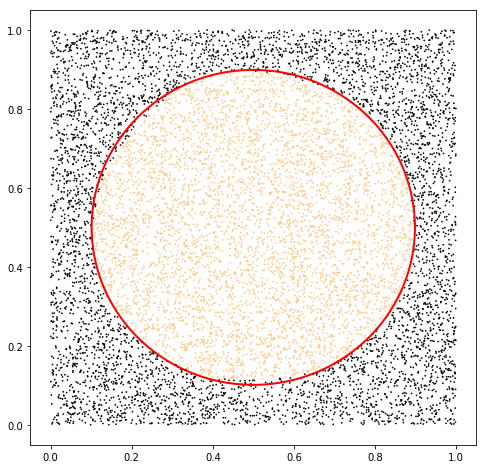

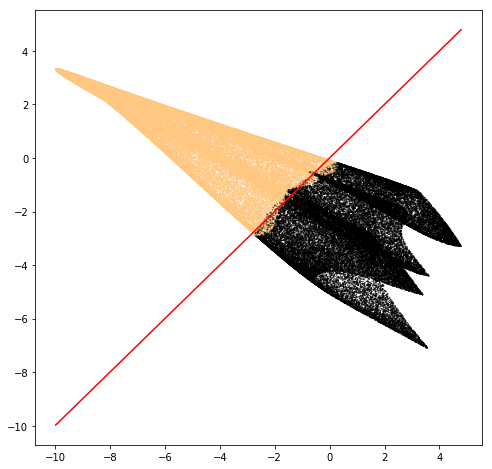

In [10]:
# crossEntropyLoss

test_input,test_target=generate_disc_set(10000)
test_input.sub_(mean).div_(std)
output=torch.empty(10000,2)
decision=torch.empty(10000)
for j in range(test_target.shape[0]):  
    output[j,:]=net.forward(test_input[j,:])
    decision[j]= int(bool(output[j,:].argmax()))


fig=plt.figure(figsize=(8, 8))
color=decision
circle1=plt.Circle((0.5,0.5), 1/math.sqrt(2*math.pi),linewidth=2 ,color='r',fill=False)
plt.gcf().gca().add_artist(circle1)
test_input.mul_(std).add_(mean)
plt.scatter(test_input[:,0],test_input[:,1],c=color,s=0.5,cmap='copper')
plt.show()
        
test_input,test_target=generate_disc_set(100000)
test_input.sub_(mean).div_(std)
output=torch.empty(100000,2)
decision=torch.empty(100000)
for j in range(test_target.shape[0]):  
    output[j,:]=net.forward(test_input[j,:])

fig=plt.figure(figsize=(8, 8))
color=test_target
plt.plot([torch.min(output[:,0]),torch.max(output[:,0])],[torch.min(output[:,0]),torch.max(output[:,0])],c='r')
plt.scatter(output[:,0],output[:,1],c=color,marker='.',s=0.5,cmap='copper')
plt.show()